<a href="https://colab.research.google.com/github/kommurisi/Individual_SiddiKommuri_HandlingMissingData-Titanic/blob/main/Siddi_Causality_Written_Section_002374754.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crash Course in Causality Written Section

Siddi Suhas Kommuri - 002374754


# Abstract

This notebook explores the causal relationship between **gender (female vs. male)** and **survival probability** on the Titanic.
Instead of purely predicting who survived, we focus on estimating the **causal effect** of being female on survival after adjusting for
other important variables such as passenger class, age, fare, family size, and embarkation port.

Using the Titanic dataset (popular on Kaggle), we:

- Define a clear **treatment** (`female`), **outcome** (`survived`), and a set of **confounders**.
- Build **propensity score models** to approximate a randomized experiment.
- Apply multiple causal estimators: **regression adjustment**, **propensity stratification**, **inverse probability weighting (IPW)**,
  **doubly-robust (AIPW)**, and **propensity score matching (PSM)** using the DoWhy library.
- Perform basic **diagnostics** using standardized mean differences (SMDs) and Love plots to check covariate balance.

The goal is to provide a compact but complete “mini-chapter” on causality, showcasing how causal methods can be used in a familiar dataset
to move from simple correlations to more defensible cause-and-effect statements.


<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/RMS_Titanic_3.jpg" alt="Titanic" width="800">
</div>


# Causality

**Causality** deals with understanding how changing one factor leads to a change in another.  
Instead of asking *“Are women more likely to survive?”* we ask:  

> *“What would happen to a passenger’s probability of survival if we could intervene
> and change their gender from male to female, keeping everything else the same?”*

This “what if” question is at the heart of causal inference and is often expressed using potential outcomes:

- \( Y(1) \): Survival outcome if a passenger were **female**.
- \( Y(0) \): Survival outcome if the same passenger were **male**.
- The **Average Treatment Effect (ATE)** is:  
  \[
    \text{ATE} = E[Y(1) - Y(0)]
  \]

Because we never observe both \( Y(1) \) and \( Y(0) \) for the same person, we use assumptions and statistical methods to approximate
this causal effect from observational data.


# Why Should We Use Causality?

Machine learning models can predict survival with high accuracy, but **prediction is not the same as causation**. For example:

- A model might learn that passengers in first class survive more often, but this does not tell us what would happen if we
  *moved a specific passenger* from third class to first class.
- Without causal thinking, we can easily confuse **spurious correlations** with true causes.

Causality helps answer questions like:

- “What is the effect of giving priority to women and children on survival?”
- “How much of the survival advantage is due to class vs. gender?”
- “What policies or interventions would change outcomes, rather than just correlate with them?”

In this notebook, we use causal tools to estimate the effect of gender on survival while controlling for other relevant variables.


# Problem Statement and Dataset

**Causal Question**

We will study:

> *What is the causal effect of being female (treatment) on survival (outcome) on the Titanic, given observed passenger characteristics?*

Formally:

- **Treatment \(T\)**: `female`  
  - \( T = 1 \): passenger is female  
  - \( T = 0 \): passenger is male  
- **Outcome \(Y\)**: `survived` (1 = survived, 0 = did not survive)
- **Confounders \(X\)**: variables that may affect both gender and survival, such as:
  - Passenger class (`class`)
  - Age (`age`)
  - Fare (`fare`)
  - Number of siblings/spouses (`sibsp`)
  - Number of parents/children (`parch`)
  - Embarkation port (`embarked`, `embark_town`)
  - Social description (`who`)
  - Travelling alone or not (`alone`)

**Dataset**

We use the built-in **Titanic** dataset from Seaborn, which is derived from the Kaggle Titanic competition. It contains
information on passengers such as age, sex, class, fare, and whether they survived. This dataset is small, easy to explore,
and widely used for teaching both classification and causal inference.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.max_columns", 200)
sns.set_theme(style="whitegrid")
%matplotlib inline


In [4]:
# Load Titanic dataset from seaborn
titanic = sns.load_dataset("titanic").copy()

# Create treatment (female) and outcome (survived) variables
titanic["female"] = (titanic["sex"] == "female").astype(int)
titanic["survived"] = titanic["survived"].astype(int)

# Choose confounders we will adjust for
confounders = [
    "class", "age", "fare", "sibsp", "parch",
    "embarked", "who", "alone", "embark_town"
]

# Keep only the columns we need
cols = ["survived", "female"] + confounders
titanic = titanic[cols].copy()

print("Shape:", titanic.shape)
titanic.head()


Shape: (891, 11)


,survived,female,class,age,fare,sibsp,parch,embarked,who,alone,embark_town
0,0,0,Third,22.0,7.2500,1,0,S,man,False,Southampton
1,1,1,First,38.0,71.2833,1,0,C,woman,False,Cherbourg
2,1,1,Third,26.0,7.9250,0,0,S,woman,True,Southampton
3,1,1,First,35.0,53.1000,1,0,S,woman,False,Southampton
4,0,0,Third,35.0,8.0500,0,0,S,man,True,Southampton


# Exploratory Data Analysis

Before applying causal methods, we briefly explore the data:

- Understand the **distribution** of the outcome (survival rate)
- Check the **distribution of treatment** (proportion of females vs males)
- Look for **missing values**
- Generate basic **summary statistics** for continuous variables

This helps us understand how biased the raw comparison might be and whether
there are strong imbalances between treated and control groups.


Overall survival rate: 0.384
Proportion of females: 0.352

Missing values:
 survived         0
female           0
class            0
age            177
fare             0
sibsp            0
parch            0
embarked         2
who              0
alone            0
embark_town      2
dtype: int64

Unadjusted ATE (female - male): 0.553


/tmp/ipython-input-1286156735.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Male (0)", "Female (1)"])


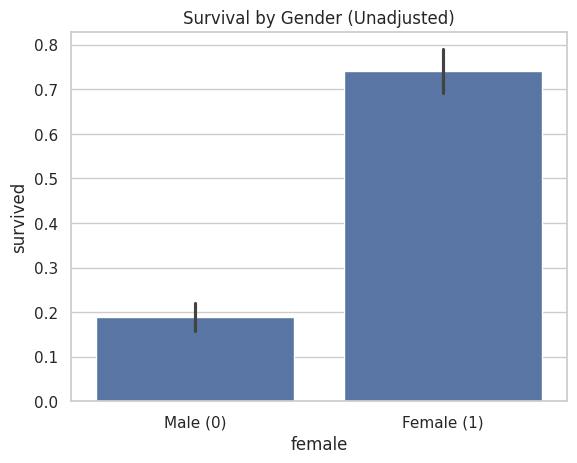

In [7]:
Y = titanic["survived"]
T = titanic["female"]

print("Overall survival rate:", Y.mean().round(3))
print("Proportion of females:", T.mean().round(3))
print("\nMissing values:\n", titanic.isna().sum())

unadjusted_ate = Y[T==1].mean() - Y[T==0].mean()
print("\nUnadjusted ATE (female - male):", round(unadjusted_ate, 3))

fig, ax = plt.subplots()
sns.barplot(data=titanic, x="female", y="survived", ax=ax)
ax.set_xticklabels(["Male (0)", "Female (1)"])
ax.set_title("Survival by Gender (Unadjusted)")
plt.show()


In [9]:
confounders = ["class", "age", "fare", "sibsp", "parch",
               "embarked", "who", "alone", "embark_town"]

cols = ["survived", "female"] + confounders
titanic = titanic[cols].copy()

X = titanic[confounders]
Y = titanic["survived"]
T = titanic["female"]

titanic.head()


,survived,female,class,age,fare,sibsp,parch,embarked,who,alone,embark_town
0,0,0,Third,22.0,7.2500,1,0,S,man,False,Southampton
1,1,1,First,38.0,71.2833,1,0,C,woman,False,Cherbourg
2,1,1,Third,26.0,7.9250,0,0,S,woman,True,Southampton
3,1,1,First,35.0,53.1000,1,0,S,woman,False,Southampton
4,0,0,Third,35.0,8.0500,0,0,S,man,True,Southampton


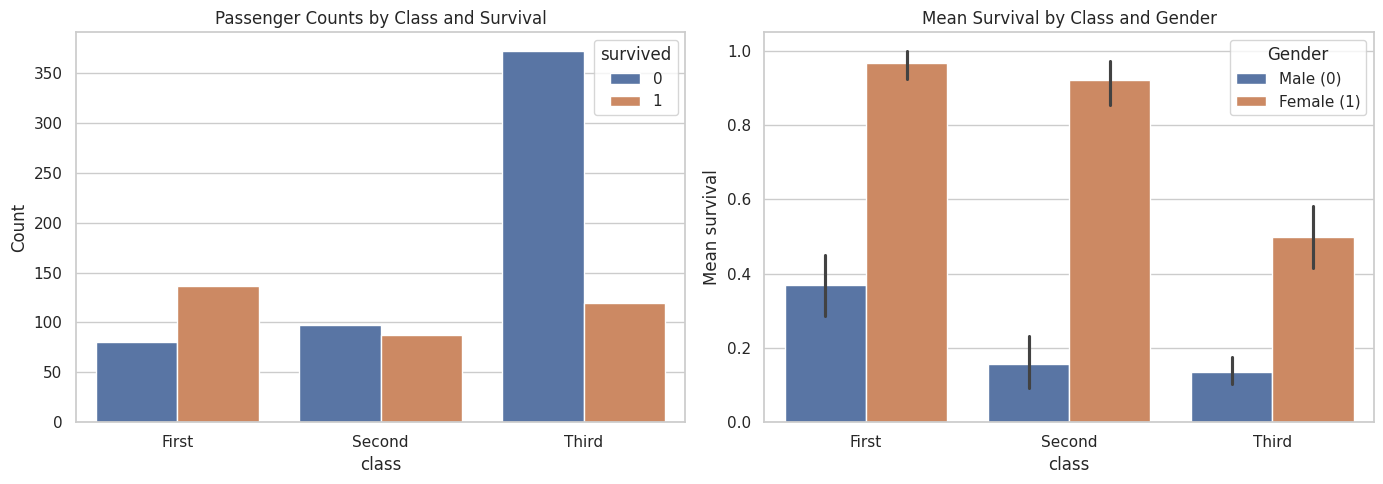

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count of passengers by class & survival
sns.countplot(data=titanic, x="class", hue="survived", ax=axes[0])
axes[0].set_title("Passenger Counts by Class and Survival")
axes[0].set_ylabel("Count")

# Survival rate by class & gender (using 'female' instead of 'sex')
sns.barplot(data=titanic, x="class", y="survived", hue="female", ax=axes[1])
axes[1].set_title("Mean Survival by Class and Gender")
axes[1].set_ylabel("Mean survival")

# Make legend labels nicer: 0 -> Male, 1 -> Female
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, ["Male (0)", "Female (1)"], title="Gender")

plt.tight_layout()
plt.show()


We see that:

- Survival is much higher in **1st class** compared to 3rd class.
- Within each class, **females** tend to have higher survival rates than males.

This suggests that both **class** and **gender** are strongly related to survival, and class is a potential confounder.


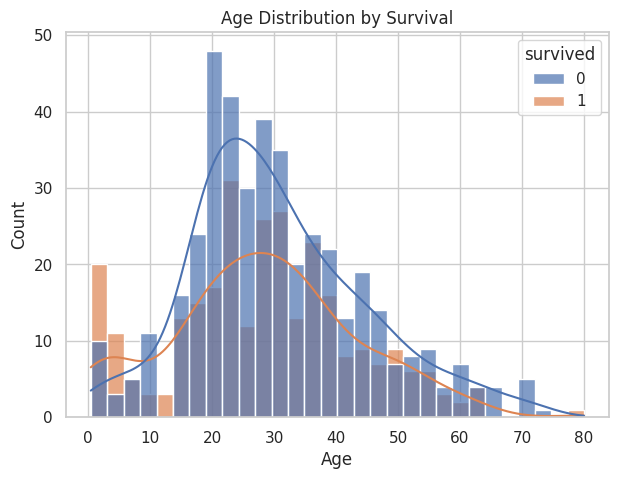

In [20]:
plt.figure(figsize=(7, 5))
sns.histplot(data=titanic, x="age", hue="survived",
             bins=30, kde=True, alpha=0.7)
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


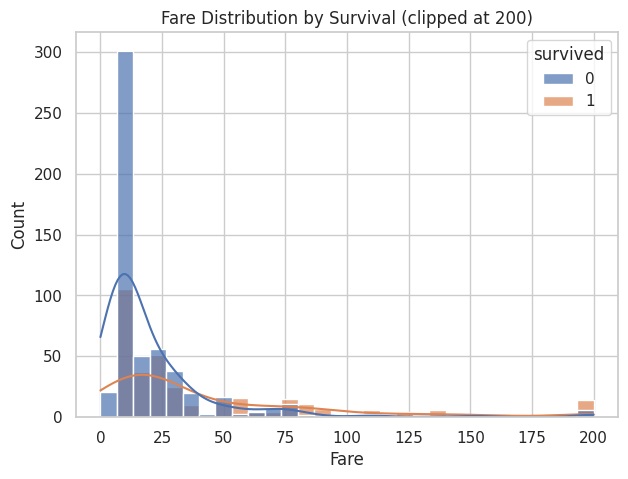

In [21]:
plt.figure(figsize=(7, 5))
titanic["fare_clipped"] = np.clip(titanic["fare"], 0, 200)  # avoid a few extreme outliers
sns.histplot(data=titanic, x="fare_clipped", hue="survived",
             bins=30, kde=True, alpha=0.7)
plt.title("Fare Distribution by Survival (clipped at 200)")
plt.xlabel("Fare")
plt.ylabel("Count")
plt.show()


## Step 4 – Preprocessing (Imputation and One-Hot Encoding)

Most causal estimators we use rely on regression or classification models. These models require:

- No missing values
- Numeric input features

Therefore we:

1. **Impute** missing values  
   - Numeric features: median imputation  
   - Categorical features: most frequent category  

2. **One-hot encode** categorical variables into 0/1 dummy columns.

We build a `ColumnTransformer` pipeline so the same preprocessing can be reused for propensity score estimation and outcome models.


In [10]:
num_features = ["age", "fare", "sibsp", "parch"]
cat_features = ["class", "embarked", "who", "alone", "embark_town"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_features),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ],
    remainder="drop"
)


## Step 5 – Propensity Scores and Overlap

The **propensity score** is the probability of receiving the treatment given the confounders:

\[
e(X) = P(T = 1 \mid X)
\]

We estimate \(e(X)\) using logistic regression with the preprocessed features.  
We then:

- Summarize the distribution of propensity scores.
- Plot histograms of scores for treated vs. control groups.

Good **overlap** (similar ranges of scores for both groups) is important for reliable causal estimation.


Propensity score summary:
count    891.000
mean       0.352
std        0.444
min        0.001
25%        0.008
50%        0.011
75%        0.981
max        0.996
dtype: float64


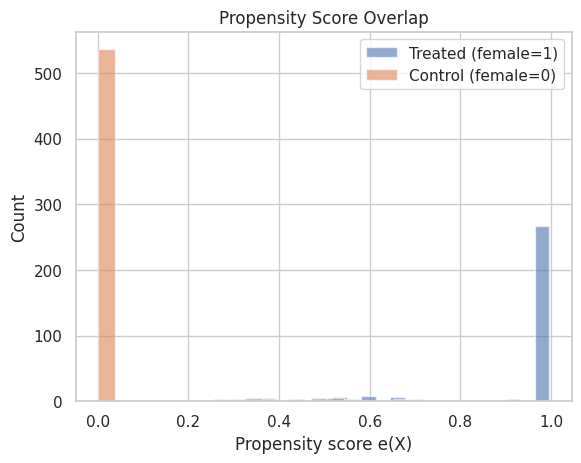

In [11]:
# Logistic regression for propensity scores
ps_model = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500))
])

ps_model.fit(X, T)
ps = ps_model.predict_proba(X)[:, 1]

print("Propensity score summary:")
print(pd.Series(ps).describe().round(3))

# Overlap plot
fig, ax = plt.subplots()
ax.hist(ps[T==1], bins=20, alpha=0.6, label="Treated (female=1)")
ax.hist(ps[T==0], bins=20, alpha=0.6, label="Control (female=0)")
ax.set_title("Propensity Score Overlap")
ax.set_xlabel("Propensity score e(X)")
ax.set_ylabel("Count")
ax.legend()
plt.show()


## Step 6 – Covariate Balance and Love Plot

After estimating propensity scores, we can use **Inverse Probability Weights (IPW)** to reweight the data so that treated and control
groups look more similar on the confounders.

To check how well this works, we compute **Standardized Mean Differences (SMDs)** for each feature:

\[
\text{SMD} = \frac{\bar{x}_\text{treated} - \bar{x}_\text{control}}
{\sqrt{\frac{1}{2}(s^2_\text{treated} + s^2_\text{control})}}
\]

We compare SMDs:

- **Before weighting**
- **After IPW weighting**

Then, we visualize them in a **Love plot**. Values with \(|\text{SMD}| < 0.1\) are often considered well balanced.


In [12]:
# Build encoded matrix for balance
X_encoded = Pipeline([("prep", preprocess)]).fit_transform(X)
ohe = ps_model.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_names)
X_df = pd.DataFrame(X_encoded, columns=feature_names)

def smd_weighted(X_df, T, w=None):
    """Weighted standardized mean differences for each column."""
    Xv = X_df.values
    T = np.asarray(T)
    if w is None:
        w = np.ones_like(T, dtype=float)

    treated = (T == 1)
    control = (T == 0)

    def wmean(v, mask):
        return np.average(v[mask], weights=w[mask])

    def wvar(v, mask):
        m = wmean(v, mask)
        return np.average((v[mask] - m)**2, weights=w[mask])

    smds = {}
    for j, col in enumerate(X_df.columns):
        vt = wmean(Xv[:, j], treated)
        vc = wmean(Xv[:, j], control)
        st = np.sqrt(wvar(Xv[:, j], treated))
        sc = np.sqrt(wvar(Xv[:, j], control))
        denom = np.sqrt(0.5 * (st**2 + sc**2)) + 1e-12
        smds[col] = (vt - vc) / denom
    return pd.Series(smds)

# Stabilized IPW weights
treat_prob = T.mean()
w_ipw = np.where(T==1, treat_prob/ps, (1 - treat_prob)/(1 - ps))

smd_before = smd_weighted(X_df, T)
smd_after  = smd_weighted(X_df, T, w=w_ipw)

balance = pd.DataFrame({
    "SMD_before": smd_before,
    "SMD_after_IPW": smd_after
}).sort_values("SMD_before", key=np.abs, ascending=False)

balance.head(10)


,SMD_before,SMD_after_IPW
who_man,-5.181699,-3.658082
who_woman,3.550303,2.609475
alone_True,-0.659252,-0.627585
alone_False,0.659252,0.627585
parch,0.491800,0.481493
fare,0.371374,0.343553
class_Third,-0.289063,-0.238361
embarked_S,-0.247084,-0.198851
embark_town_Southampton,-0.247084,-0.198851
sibsp,0.238514,0.274615


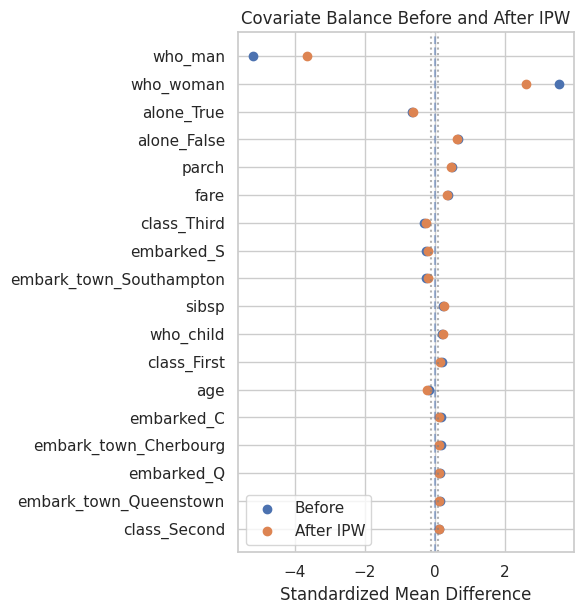

In [13]:
fig, ax = plt.subplots(figsize=(6, min(10, 0.35 * len(balance))))
idx = balance.index

ax.scatter(balance["SMD_before"], np.arange(len(idx)), label="Before")
ax.scatter(balance["SMD_after_IPW"], np.arange(len(idx)), label="After IPW")

ax.axvline(0, linestyle="--", alpha=0.5)
ax.axvline(0.1, color="gray", linestyle=":", alpha=0.6)
ax.axvline(-0.1, color="gray", linestyle=":", alpha=0.6)

ax.set_yticks(np.arange(len(idx)))
ax.set_yticklabels(idx)
ax.invert_yaxis()
ax.set_xlabel("Standardized Mean Difference")
ax.set_title("Covariate Balance Before and After IPW")
ax.legend()
plt.tight_layout()
plt.show()


## Step 7 – Causal Estimators

We now estimate the Average Treatment Effect (ATE) of `female` on `survived` using several methods:

1. **Unadjusted difference** – simple difference in mean survival between females and males.
2. **Regression Adjustment (RA)** – model \(E[Y \mid T, X]\) and use it to predict potential outcomes \(Y(1)\) and \(Y(0)\).
3. **Propensity Stratification** – group passengers into strata by propensity score and compare treated vs control within each stratum.
4. **Inverse Probability Weighting (IPW)** – reweight observations by inverse propensity to create a pseudo-population.
5. **Doubly-Robust AIPW** – combines outcome model and IPW; consistent if either model is correctly specified.

Comparing these estimators helps check robustness of the causal conclusions.


In [14]:
# Outcome model: logistic regression on [X_encoded, T]
X_design = np.hstack([X_df.values, T.values.reshape(-1, 1)])
y = Y.values

outcome_model = LogisticRegression(max_iter=1000)
outcome_model.fit(X_design, y)

# Predict potential outcomes for everyone
X1 = np.hstack([X_df.values, np.ones((len(T), 1))])
X0 = np.hstack([X_df.values, np.zeros((len(T), 1))])

mu1 = outcome_model.predict_proba(X1)[:, 1]
mu0 = outcome_model.predict_proba(X0)[:, 1]

ate_reg = (mu1 - mu0).mean()
print("ATE – Regression Adjustment:", round(ate_reg, 3))


ATE – Regression Adjustment: 0.049


In [15]:
# Stratify on propensity scores into 5 bins
strata = pd.qcut(ps, q=5, labels=False, duplicates="drop")
df_strata = pd.DataFrame({"Y": Y, "T": T, "stratum": strata})

stratum_ates = []
weights = []

for s, g in df_strata.groupby("stratum"):
    if g["T"].nunique() < 2:
        continue
    diff = g.loc[g["T"]==1, "Y"].mean() - g.loc[g["T"]==0, "Y"].mean()
    stratum_ates.append(diff)
    weights.append(len(g))

ate_strat = np.average(stratum_ates, weights=weights)
print("ATE – Propensity Stratification (5 bins):", round(ate_strat, 3))


ATE – Propensity Stratification (5 bins): 0.217


In [16]:
# IPW ATE
ate_ipw = ( (w_ipw * T * Y).sum() / (w_ipw * T).sum()
          ) - ( (w_ipw * (1 - T) * Y).sum() / (w_ipw * (1 - T)).sum() )

print("ATE – IPW:", round(ate_ipw, 3))

# Doubly-Robust AIPW
aipw_score = (T * (Y - mu1) / ps) - ((1 - T) * (Y - mu0) / (1 - ps)) + (mu1 - mu0)
ate_aipw = aipw_score.mean()
print("ATE – Doubly-Robust (AIPW):", round(ate_aipw, 3))


ATE – IPW: 0.5
ATE – Doubly-Robust (AIPW): 0.046


## Step 8 – Summary of Estimated Effects

To see all methods side by side, we create a small summary table with:

- Unadjusted difference in survival
- Regression Adjustment
- Stratification
- IPW
- Doubly-Robust AIPW

This allows us to check whether different estimators give similar answers for the ATE of `female` on `survived`.


## Step 8 – Summary of Estimated Effects

To see all methods side by side, we create a small summary table with:

- Unadjusted difference in survival
- Regression Adjustment
- Stratification
- IPW
- Doubly-Robust AIPW

This allows us to check whether different estimators give similar answers for the ATE of `female` on `survived`.


In [17]:
summary = pd.Series({
    "Unadjusted difference": unadjusted_ate,
    "Regression Adjustment": ate_reg,
    "Stratification (5 bins)": ate_strat,
    "IPW": ate_ipw,
    "AIPW (Doubly-Robust)": ate_aipw
}).round(3)

summary


,0
Unadjusted difference,0.553
Regression Adjustment,0.049
Stratification (5 bins),0.217
IPW,0.500
AIPW (Doubly-Robust),0.046
